In [ ]:
# matplotlib.use('Agg') # Removed to allow inline notebook plotting
import os
import psutil

# Set OMP_NUM_THREADS to avoid overhead on large machines
if "OMP_NUM_THREADS" not in os.environ:
    n_cores = psutil.cpu_count(logical=False)
    os.environ["OMP_NUM_THREADS"] = str(n_cores)
    print(f"OMP_NUM_THREADS set to {n_cores}")

from pysm3 import Sky
from pysm3 import units as u

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.table import Table
from pysm3.models.websky import y2uK_CMB

OMP_NUM_THREADS set to 128


In [ ]:
import logging
logging.getLogger("pysm3").setLevel(logging.INFO)

In [ ]:
def remove_monopole(m):
    mono = np.mean(m)
    return m - mono, mono

def joint_limits(map_dict, percentile=99.5):
    stacked = np.concatenate([m.value.ravel() for m in map_dict.values()])
    vmax = np.percentile(np.abs(stacked), percentile)
    if vmax <= 0:
        vmax = np.max(np.abs(stacked))
    if vmax == 0:
        vmax = 1.0
    vmax = float(f"{vmax:.2g}")
    return -vmax, vmax

# SZ realization comparisons

Summary plots and statistics for the thermal and kinematic SZ components.

In [ ]:
models = ["tsz1", "tsz2", "tsz3", "tsz4"]
model_titles = {
    "tsz1": "WebSky tSZ",
    "tsz2": "Agora tSZ",
    "tsz3": "Agora tSZ (lensed)",
    "tsz4": "HalfDome tSZ",
}

skys = {model: Sky(nside=2048, preset_strings=[model], output_unit=u.uK_CMB) for model in models}

freq_ghz = 143
maps = {}
for model in models:
    cache_file = f"data/cache_tsz_{model}_{freq_ghz}GHz.fits"
    if os.path.exists(cache_file):
        print(f"Loading {model} tSZ from cache: {cache_file}")
        maps[model] = hp.read_map(cache_file, verbose=False) * u.dimensionless_unscaled
    else:
        print(f"Computing {model} tSZ at {freq_ghz} GHz...")
        maps[model] = skys[model].get_emission(freq_ghz * u.GHz)[0] / y2uK_CMB(freq_ghz)
        hp.write_map(cache_file, maps[model].value, overwrite=True)

Loading tsz1 tSZ from cache: data/cache_tsz_tsz1_143GHz.fits


/tmp/ipykernel_1558934/795449475.py:17: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  maps[model] = hp.read_map(cache_file, verbose=False) * u.dimensionless_unscaled


Loading tsz2 tSZ from cache: data/cache_tsz_tsz2_143GHz.fits
Loading tsz3 tSZ from cache: data/cache_tsz_tsz3_143GHz.fits
Loading tsz4 tSZ from cache: data/cache_tsz_tsz4_143GHz.fits


Monopoles removed (Compton-y):
  WebSky tSZ: 1.238e-06
  Agora tSZ: 2.053e-06
  Agora tSZ (lensed): 2.053e-06
  HalfDome tSZ: 1.031e-06


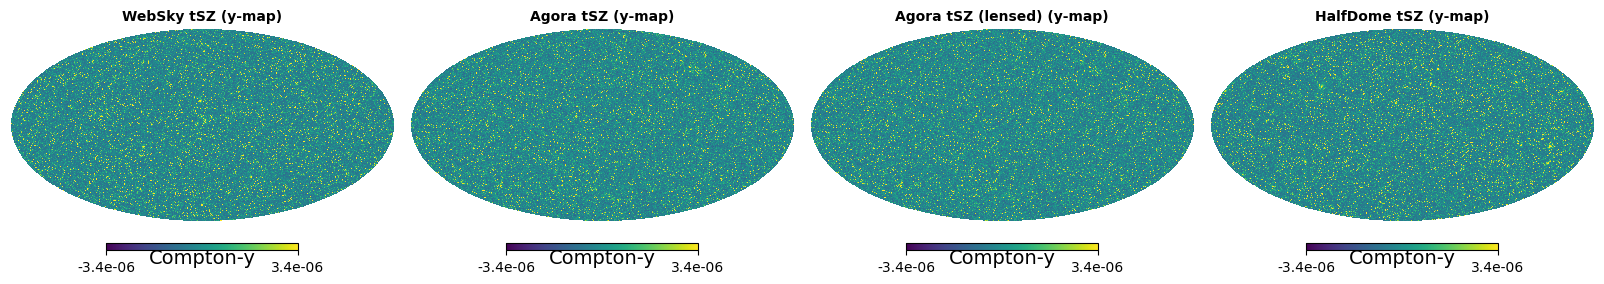

In [ ]:
n_rows = 1
n_cols = len(models)
fig = plt.figure(figsize=(4.0 * n_cols, 4.2 * n_rows))
monopoles = {}

# Compute joint limits across all models in Compton-y
stacked = np.concatenate([maps[model].value.ravel() for model in models])
vmax = np.percentile(np.abs(stacked), 95)
if vmax <= 0:
    vmax = np.max(np.abs(stacked))
if vmax == 0:
    vmax = 1.0
vmax = float(f"{vmax:.2g}")
vmin = -vmax

for col_idx, model in enumerate(models, start=1):
    component = maps[model]
    centered_map, mono = remove_monopole(component)
    monopoles[model] = mono
    hp.mollview(
        centered_map,
        sub=(n_rows, n_cols, col_idx),
        fig=fig,
        min=vmin,
        max=vmax,
        unit="Compton-y",
        title="",
    )
    ax = plt.gca()
    ax.text(
        0.5,
        1.03,
        f"{model_titles[model]} (y-map)",
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.subplots_adjust(hspace=0.45, top=0.88)

print("Monopoles removed (Compton-y):")
for model in models:
    print(f"  {model_titles[model]}: {monopoles[model]:.3e}")

Summary of tsz3 - tsz2 differences in Compton-y:
  mean: 1.893e-11, rms: 5.406e-07, |diff|_99%: 1.964e-06


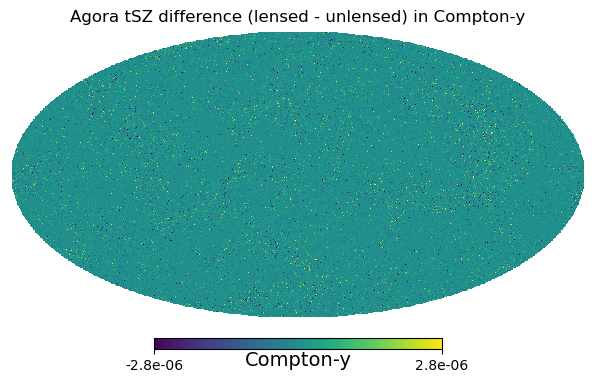

In [ ]:
diff = maps["tsz3"] - maps["tsz2"]
diff_data = diff.value
vmax = np.percentile(np.abs(diff_data), 99.5)
if vmax <= 0:
    vmax = np.max(np.abs(diff_data))
if vmax == 0:
    vmax = 1.0
vmax = float(f"{vmax:.2g}")
hp.mollview(
    diff_data,
    fig=plt.figure(figsize=(6, 4)),
    min=-vmax,
    max=vmax,
    unit="Compton-y",
    title=f"Agora tSZ difference (lensed - unlensed) in Compton-y",
)
diff_stats = {
    "mean": float(np.mean(diff_data)),
    "rms": float(np.sqrt(np.mean(diff_data**2))),
    "p99": float(np.percentile(np.abs(diff_data), 99.0)),
}

print(f"Summary of tsz3 - tsz2 differences in Compton-y:")
print(
    f"  mean: {diff_stats['mean']:.3e}, rms: {diff_stats['rms']:.3e}, |diff|_99%: {diff_stats['p99']:.3e}"
)

### Reference: WebSky Figure 5 (tSZ)
![WebSky Figure 5](figure5.png)

*Comparison note*: The plot below shows the Compton-y power spectrum in log-log scale.

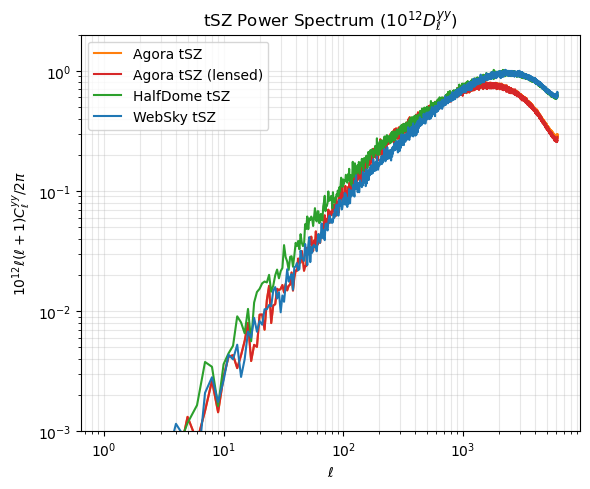

In [ ]:
lmax = 3 * 2048 - 1
ells = np.arange(lmax + 1)
d_ell_factor = ells * (ells + 1) / (2 * np.pi)

color_options = [
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:orange",
]
model_colors = {
    "tsz1": "tab:blue",
    "tsz2": "tab:orange",
    "tsz3": "tab:red",
    "tsz4": "tab:green",
}

fig, ax = plt.subplots(figsize=(6, 5))
# Plot tsz1 (WebSky) last to ensure it is on top
for model in (models[1:] + [models[0]]):
    cls = hp.anafast(maps[model].value, lmax=lmax)
    # Dimensionless y-spectrum * 10^12
    d_ell_12 = d_ell_factor * cls * 1e12
    ax.loglog(ells[1:], d_ell_12[1:], color=model_colors[model], label=model_titles[model])

ax.set_title(f"tSZ Power Spectrum ($10^{{12}} D_\\ell^{{yy}}$)")
ax.set_xlabel("$\\ell$")
ax.set_ylabel("$10^{12} \\ell(\\ell+1)C_\\ell^{yy} / 2\\pi$")
ax.grid(True, which="both", alpha=0.3)
ax.legend(loc="upper left")
ax.set_ylim(1e-3, 2.0)
fig.tight_layout()
fig.savefig("tsz_power_spectrum.png")

In [ ]:
# Kinematic SZ Comparisons
ksz_models = ["ksz1", "ksz2", "ksz3"]
ksz_titles = {
    "ksz1": "WebSky kSZ",
    "ksz2": "Agora kSZ",
    "ksz3": "Agora kSZ (lensed)",
}
ksz_freq = 143
ksz_skys = {model: Sky(nside=2048, preset_strings=[model], output_unit=u.uK_CMB) for model in ksz_models}
ksz_maps = {}
for model in ksz_models:
    cache_file = f"data/cache_ksz_{model}_{ksz_freq}GHz.fits"
    if os.path.exists(cache_file):
        print(f"Loading {model} kSZ from cache: {cache_file}")
        ksz_maps[model] = hp.read_map(cache_file, field=(0, 1, 2), verbose=False) * u.uK_CMB
    else:
        print(f"Computing {model} kSZ at {ksz_freq} GHz...")
        ksz_maps[model] = ksz_skys[model].get_emission(ksz_freq * u.GHz)
        hp.write_map(cache_file, ksz_maps[model].to_value(u.uK_CMB), overwrite=True)
ksz_colors = {
    "ksz1": "tab:gray",
    "ksz2": "tab:orange",
    "ksz3": "tab:red",
}
ksz_unit = str(next(iter(ksz_maps.values()))[0].unit)
print(
    f"Loaded kSZ templates at {ksz_freq} GHz (units: {ksz_unit}) -> "
    + ", ".join(ksz_titles[model] for model in ksz_models)
)

Loading ksz1 kSZ from cache: data/cache_ksz_ksz1_143GHz.fits


/tmp/ipykernel_1558934/165830930.py:15: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  ksz_maps[model] = hp.read_map(cache_file, field=(0, 1, 2), verbose=False) * u.uK_CMB


Loading ksz2 kSZ from cache: data/cache_ksz_ksz2_143GHz.fits
Loading ksz3 kSZ from cache: data/cache_ksz_ksz3_143GHz.fits
Loaded kSZ templates at 143 GHz (units: uK_CMB) -> WebSky kSZ, Agora kSZ, Agora kSZ (lensed)


kSZ monopoles removed (units in uK_CMB ):
  WebSky kSZ: -1.866e-01 uK_CMB
  Agora kSZ: 4.191e-02 uK_CMB
  Agora kSZ (lensed): 4.148e-02 uK_CMB


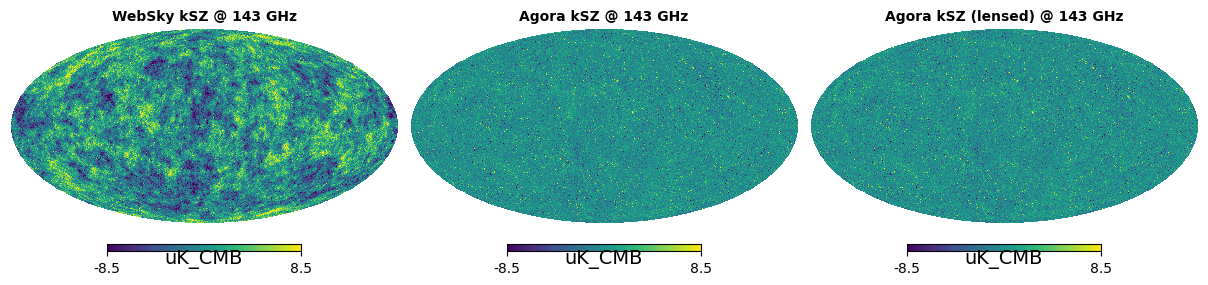

In [ ]:
fig = plt.figure(figsize=(4.0 * len(ksz_models), 4.0))
stacked = np.concatenate([ksz_maps[model][0].value.ravel() for model in ksz_models])
vmax = np.percentile(np.abs(stacked), 99.5)
if vmax <= 0:
    vmax = np.max(np.abs(stacked))
if vmax == 0:
    vmax = 1.0
vmax = float(f"{vmax:.2g}")
vmin = -vmax
ksz_monopoles = {}
for col_idx, model in enumerate(ksz_models, start=1):
    component = ksz_maps[model][0]
    centered_map, mono = remove_monopole(component)
    ksz_monopoles[model] = mono
    hp.mollview(
        centered_map,
        sub=(1, len(ksz_models), col_idx),
        fig=fig,
        min=vmin,
        max=vmax,
        unit=str(component.unit),
        title="",
    )
    ax = plt.gca()
    ax.text(
        0.5,
        1.03,
        f"{ksz_titles[model]} @ {ksz_freq} GHz",
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.subplots_adjust(top=0.85, wspace=0.25)

print("kSZ monopoles removed (units in", ksz_unit, "):")
for model in ksz_models:
    print(f"  {ksz_titles[model]}: {ksz_monopoles[model]:.3e}")

Summary of kSZ differences at 143 GHz (units in uK_CMB ):
  Agora kSZ (lensed) - Agora kSZ -> mean: -4.237e-04, rms: 6.996e-01, |diff|_99%: 2.451e+00


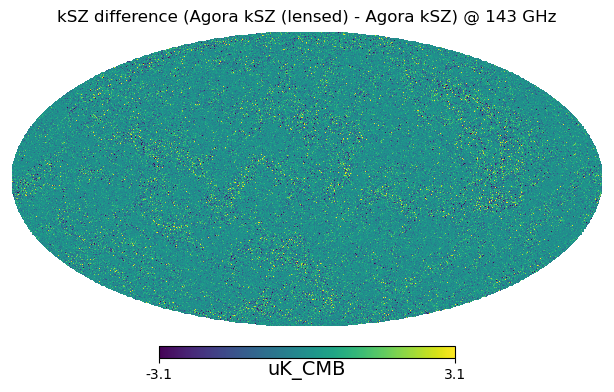

In [ ]:
ksz_diff = ksz_maps["ksz3"][0] - ksz_maps["ksz2"][0]
ksz_diff_data = ksz_diff.value
vmax = np.percentile(np.abs(ksz_diff_data), 99.5)
if vmax <= 0:
    vmax = np.max(np.abs(ksz_diff_data))
if vmax == 0:
    vmax = 1.0
vmax = float(f"{vmax:.2g}")

fig = plt.figure(figsize=(6, 3.6))
hp.mollview(
    ksz_diff_data,
    sub=(1, 1, 1),
    fig=fig,
    min=-vmax,
    max=vmax,
    unit=str(ksz_diff.unit),
    title=f"kSZ difference ({ksz_titles['ksz3']} - {ksz_titles['ksz2']}) @ {ksz_freq} GHz",
)

ksz_23_stats = {
    "mean": float(np.mean(ksz_diff_data)),
    "rms": float(np.sqrt(np.mean(ksz_diff_data**2))),
    "p99": float(np.percentile(np.abs(ksz_diff_data), 99.0)),
}

print(
    "Summary of kSZ differences at",
    ksz_freq,
    "GHz (units in",
    str(ksz_diff.unit),
    "):",
)
print(
    f"  {ksz_titles['ksz3']} - {ksz_titles['ksz2']} -> mean: {ksz_23_stats['mean']:.3e}, rms: {ksz_23_stats['rms']:.3e}, |diff|_99%: {ksz_23_stats['p99']:.3e}",
)

### Reference: WebSky Figure 6 (kSZ)
![WebSky Figure 6](figure6.png)

*Comparison note*: The kSZ power spectrum is plotted in semilogx with units of uK^2.

**Note on kSZ Differences**: The low-$\ell$ excess seen in the WebSky model is primarily due to the large-scale Doppler term (bulk flow). 
WebSky and Agora have significantly different simulation box sizes; WebSky's larger volume allows it to capture these large-scale bulk motions more effectively than Agora. 
Importantly, the high-$\ell$ behavior—which is dominated by the small-scale kinematic effect—remains (substantially) consistent between the models. 
As shown in Agora Figure 16 (below), current empirical constraints from data are at very high $\ell$ and carry large uncertainties. 

![Agora Figure 16](figure16.png)

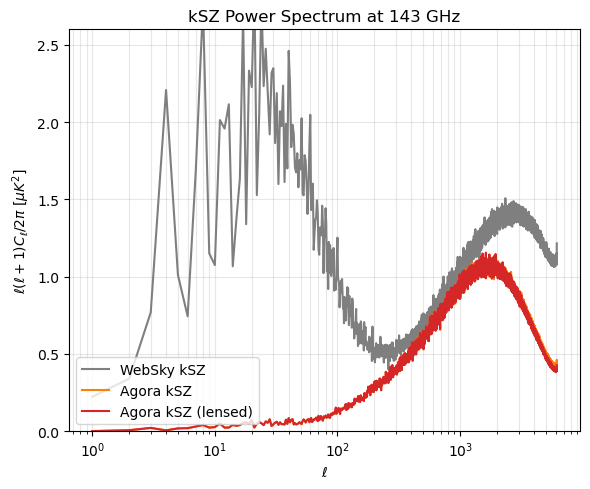

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
for model in ksz_models:
    # Maps are in uK_CMB
    cls = hp.anafast(ksz_maps[model][0].value, lmax=lmax)
    d_ell = d_ell_factor * cls
    ax.semilogx(
        ells[1:],
        d_ell[1:],
        color=ksz_colors[model],
        label=ksz_titles[model],
    )

ax.set_title(f"kSZ Power Spectrum at {ksz_freq} GHz")
ax.set_xlabel("$\\ell$")
ax.set_ylabel("$\\ell(\\ell+1)C_\\ell / 2\\pi$ [$\\mu K^2$]")
ax.grid(True, which="both", alpha=0.3)
ax.legend(loc="lower left")
ax.set_ylim(0, 2.6)
fig.tight_layout()
fig.savefig("ksz_power_spectrum.png")

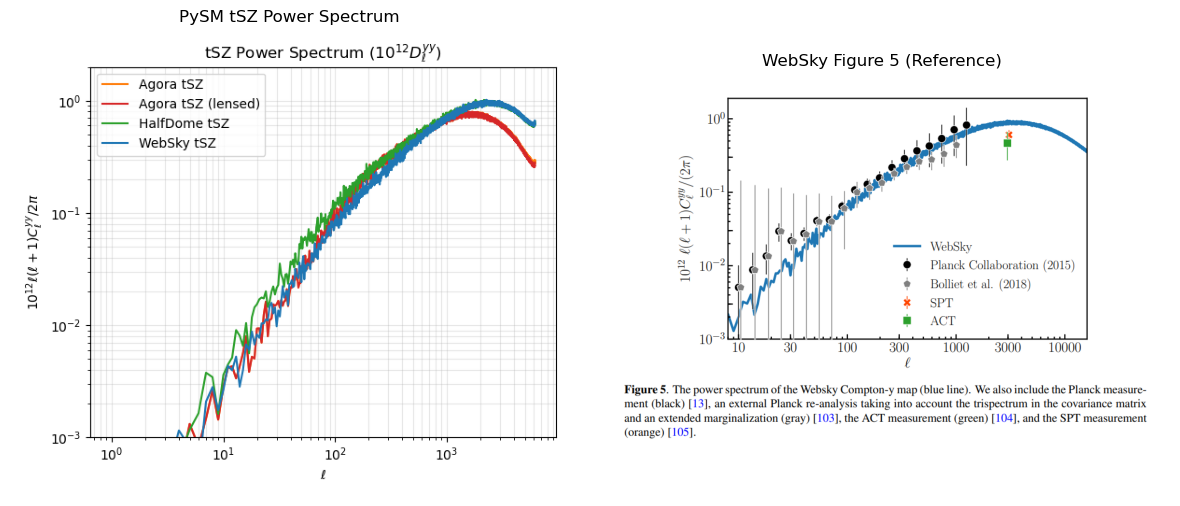

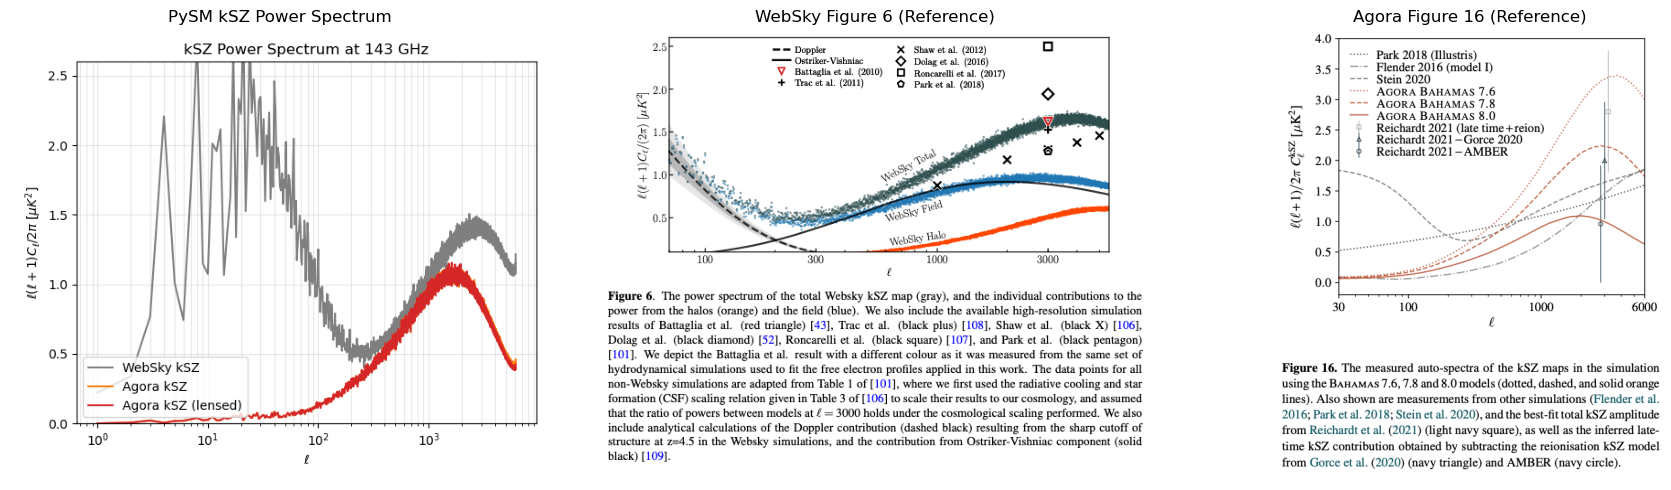

In [ ]:
# Create composite plots for report
import matplotlib.image as mpimg

fig_tsz, axes_tsz = plt.subplots(1, 2, figsize=(12, 5))
axes_tsz[0].imshow(mpimg.imread("tsz_power_spectrum.png"))
axes_tsz[0].axis("off")
axes_tsz[0].set_title("PySM tSZ Power Spectrum")
axes_tsz[1].imshow(mpimg.imread("figure5.png"))
axes_tsz[1].axis("off")
axes_tsz[1].set_title("WebSky Figure 5 (Reference)")
plt.tight_layout()
plt.savefig("tsz_composite.png")
plt.show()

fig_ksz, axes_ksz = plt.subplots(1, 3, figsize=(18, 5))
axes_ksz[0].imshow(mpimg.imread("ksz_power_spectrum.png"))
axes_ksz[0].axis("off")
axes_ksz[0].set_title("PySM kSZ Power Spectrum")
axes_ksz[1].imshow(mpimg.imread("figure6.png"))
axes_ksz[1].axis("off")
axes_ksz[1].set_title("WebSky Figure 6 (Reference)")
axes_ksz[2].imshow(mpimg.imread("figure16.png"))
axes_ksz[2].axis("off")
axes_ksz[2].set_title("Agora Figure 16 (Reference)")
plt.tight_layout()
plt.savefig("ksz_composite.png")
plt.show()